In [1]:
from gatspy.periodic import LombScargleFast
from scipy import signal
from astropy.stats import LombScargle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import time

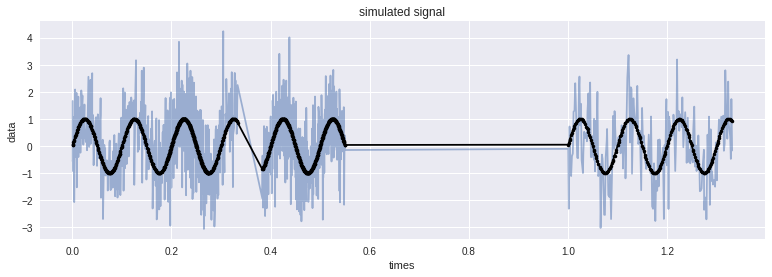

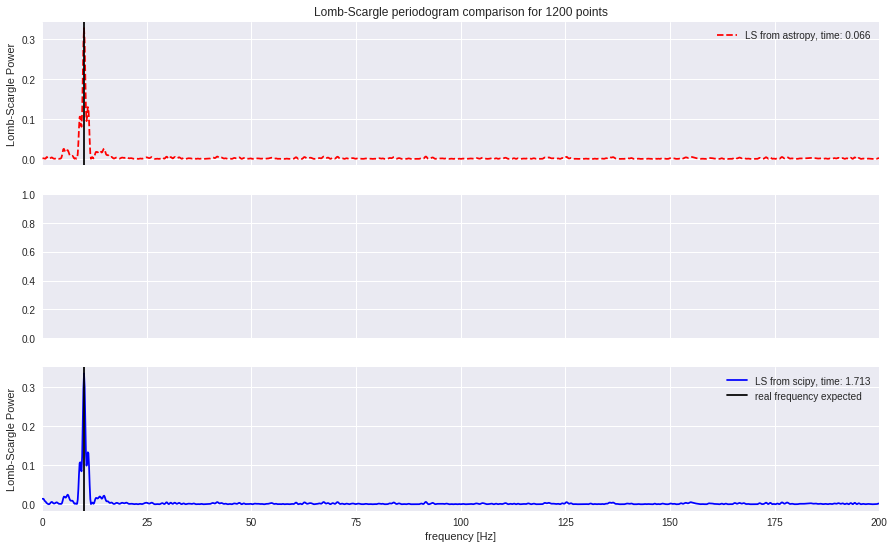

In [2]:
"""
comparison between many implementations of lomb-scargle periodogram
"""
# 3 parts separated in time, one with slight irregularities in time sampling
# another with change of spacing and the last one with big outlier in spacing
N = 1200
T = np.zeros(N)
dt_implicit = 1 / N
t0 = np.linspace(0, int(N/3)-1, int(N/3))
np.random.seed(1)
e = np.random.normal(0, dt_implicit * 0.5, N//3)
T[0:N//3] = t0 * dt_implicit + e
shift = 30 * dt_implicit

np.random.seed(2)
t0 = np.linspace(int(N/3), int(N*1/2)-1, int(N/6))
e = np.random.normal(0, dt_implicit * 0.5, N//6)
T[N//3:N//2] = shift + t0 * dt_implicit / 2 + e

np.random.seed(3)
t0 = np.linspace(int(N/2), int(N*2/3)-1, int(N/6))
e = np.random.normal(0, dt_implicit * 0.5, N//6)
T[N//2:2*N//3] = t0 * 2 * dt_implicit + e

np.random.seed(4)
t0 = np.linspace(2*N//3, N-1, N - 2*N//3)
e = np.random.normal(0, dt_implicit * 0.5, N - 2*N//3)
T[2*N//3:N] = 2 * shift + t0 * dt_implicit / 2 + e
T.sort()

#  signal is sinusoidal again with same frequency
freq_of_sin = 10
s = np.sin(freq_of_sin * 2 * np.pi * T)
#  apply noise
np.random.seed(1)
noise = np.random.normal(0, 1, N)
data = s + noise
plt.figure(0, figsize=(13, 4))
plt.plot(T, data, alpha=0.5)
plt.plot(T, s, "k.-")
plt.title("simulated signal")
plt.xlabel("times")
plt.ylabel("data")

t_i = time.time()
frequency, power = LombScargle(T, data).autopower()
t_f1 = time.time()
# gatspy is to expensive
#model = LombScargleFast().fit(T, data, None)
#periods, power2 = model.periodogram_auto(nyquist_factor=max(frequency))
t_f2 = time.time()
pgram = signal.lombscargle(T, data, frequency * 2 * np.pi, normalize=True)
t_f3 = time.time()

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(15, 9), sharex=True)
ax1.plot(frequency, power, 'r--', label="LS from astropy, time: {}".format(round(t_f1-t_i, 3)))
#ax2.plot(1 / periods, power2, 'g', alpha=0.6, label="LS from gatspy, time: {}".format(round(t_f2-t_f1, 3)))
ax3.plot(frequency, pgram, 'b', label="LS from scipy, time: {}".format(round(t_f3-t_f2, 3)))
plt.xlim([0, 200])
ax1.set_title("Lomb-Scargle periodogram comparison for {} points".format(N))
ax3.set_xlabel("frequency [Hz]")
ax1.set_ylabel("Lomb-Scargle Power")
#ax2.set_ylabel("Lomb-Scargle Power")
ax3.set_ylabel("Lomb-Scargle Power")
ax1.axvline(freq_of_sin, color='k', linestyle='solid')
ax3.axvline(freq_of_sin, color='k', linestyle='solid', label="real frequency expected")
ax1.legend()
#ax2.legend()
ax3.legend()
plt.show()


#at first sight the implementation from astropy seems to be the most faster but its necessary to run 
#several repetitions for different numbers of points to see exactply which is more faster, for know 
#this is not necessary to do


1031.6570927265452


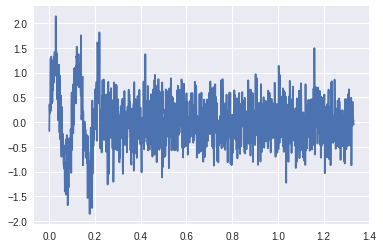

In [3]:
# welch
N = 1373
t_regular = np.linspace(min(T), max(T), N)
dt = t_regular[1] - t_regular[0]
s_regular = np.sin(freq_of_sin * 2 * np.pi * t_regular)
# set some range of values to 0
s_regular[1*(N//6):] = 0
# np.random.seed(1)
noise_regular = np.random.normal(0, 0.4, N)
s_regular = s_regular + noise_regular
plt.plot(t_regular, s_regular)
fs = len(t_regular) / (max(t_regular) - min(t_regular))
print(fs)

1373
sigma cuadrado:  0.16000000000000003
sum pxx noise: 0.21621468227863222
0.00022679672342916922 0.00022466195751980595
0.0003214420789686954 0.00031472297274910075


(0, 400)

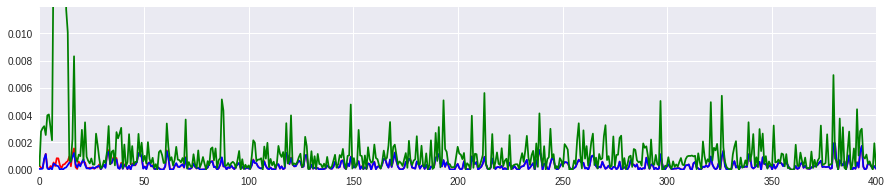

In [10]:
nper = N
print(nper)
f, Pxx_den = signal.welch(s_regular, fs, noverlap=int(nper * 5 / 10), 
                          nperseg=int(nper), return_onesided=True)
_, Pxx_den_noise = signal.welch(noise_regular, fs, noverlap=int(nper * 5 / 10), 
                          nperseg=int(nper), return_onesided=True)
# and do astropy lombscargle to compare
power = LombScargle(t_regular, s_regular).power(f[1:])
power = np.append(Pxx_den[0], power)
print("sigma cuadrado: ", 0.4**2)
print("sum pxx noise:", np.sum(Pxx_den_noise))
print(np.median(Pxx_den), np.median(Pxx_den_noise))
print(np.mean(Pxx_den), np.mean(Pxx_den_noise))
plt.figure(figsize=(15, 3))
plt.plot(f, Pxx_den, 'r')
plt.plot(f, Pxx_den_noise, 'b')
plt.plot(f, power, 'g')
plt.ylim([0, max(Pxx_den) + 0.01])
plt.xlim([0, 400])

In [5]:
np.median(Pxx_den)

0.00022679672342916922

In [6]:
np.median(power)

0.0006773871307394134

In [7]:
# what is whitening?, test the optimal case
from numpy.fft import fft, ifft, rfft, irfft

(0.015954631527993174+0j)


ValueError: x and y must have same first dimension, but have shapes (1373,) and (1372,)

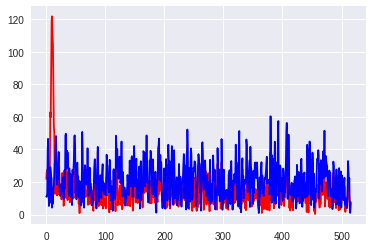

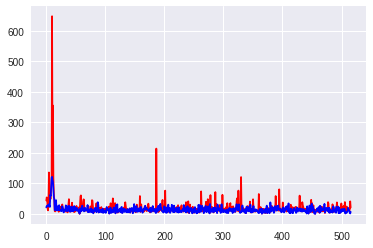

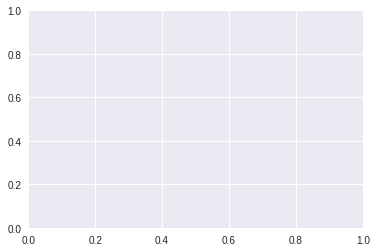

In [8]:
d_reg = rfft(s_regular)
print(d_reg[0] / N)
norm = 1 / np.sqrt(1 / (2 * dt))
# norm = 1
wt_d = d_reg / np.sqrt(Pxx_den_noise) / N / norm
plt.figure()
plt.plot(f, np.abs(d_reg), 'r')
plt.plot(f, np.sqrt(Pxx_den_noise) * N, 'b')
inverse = irfft(wt_d)
plt.figure()
plt.plot(f, abs(wt_d), 'r')
plt.plot(f, abs(d_reg), 'b')
plt.figure()
plt.plot(t_regular, inverse, 'r')
plt.plot(t_regular, s_regular, 'b', alpha=0.5)

In [11]:
n = np.random.normal(0, 1, 100)
nft = np.fft.fft(n)

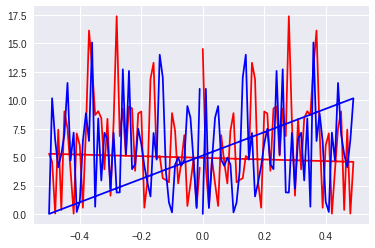

In [14]:
fq = np.fft.fftfreq(100)
plt.plot(fq, abs(nft.real), 'r')
plt.plot(fq, abs(nft.imag), 'b')